**BIOINFORMATICS AND NETWORK MEDICINE**

---


**Putative disease gene identification and drug repurposing for Obesity**

*   Rahim Rahimov / 1921843






In [2]:
# Importing the pandas library, which is widely used for data manipulation and analysis.
import pandas as pd

# Importing matplotlib's pyplot module for data visualization and plotting.
import matplotlib.pyplot as plt

# Importing NetworkX, a library designed to handle complex network structures like graphs.
import networkx as nx

# Importing seed and randint from the random module to set a random seed (ensuring reproducibility) and generate random integers, respectively.
from random import seed, randint

# Importing tqdm, a library that provides progress bars for loops to enhance readability, especially for longer-running operations.
from tqdm import tqdm

# Importing time to handle timing-related operations, like pauses or measuring execution time.
import time
import numpy as np



>  **1. PPI and GDA data gathering, cleaning and interactome reconstruction**



In [3]:
# Load tab-separated BIOGRID data for Homo sapiens into a DataFrame
data = pd.read_csv("/content/drive/MyDrive/BNM PROJECT DATA/BIOGRID-ORGANISM-Homo_sapiens-4.4.238.tab3.txt", sep="\t")

<ipython-input-3-7dd81041292c>:2: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/BNM PROJECT DATA/BIOGRID-ORGANISM-Homo_sapiens-4.4.238.tab3.txt", sep="\t")


In [4]:
# Filter for human protein-protein interactions (PPI) where both interactors have Organism ID 9606 (Homo sapiens)
human_ppi_data = data[(data["Organism ID Interactor A"] == 9606) & (data["Organism ID Interactor B"] == 9606)]

In [5]:
# Remove self-interactions where both interactors are the same protein
human_ppi_data = human_ppi_data[human_ppi_data["Official Symbol Interactor A"] != human_ppi_data["Official Symbol Interactor B"]]


In [6]:
# Keep only rows where the interaction type is physical
human_ppi_data = human_ppi_data[human_ppi_data["Experimental System Type"] == "physical"]

In [7]:
# Display the number of rows and columns in the human_ppi_data DataFrame
human_ppi_data.shape

(1135894, 37)

In [8]:
# Rename columns for simplicity
human_ppi_data = human_ppi_data.rename(columns={"Official Symbol Interactor A": "GeneA", "Official Symbol Interactor B": "GeneB"})

In [9]:
# Create an undirected graph from GeneA-GeneB interactions
ppi_graph = nx.from_pandas_edgelist(human_ppi_data, source="GeneA", target="GeneB", create_using=nx.Graph())

# Display graph size
print(f"Graph has {ppi_graph.number_of_nodes()} nodes and {ppi_graph.number_of_edges()} edges")

Graph has 19936 nodes and 855005 edges


In [10]:
# Find connected components and sort by size
connected_components = list(nx.connected_components(ppi_graph))
component_sizes = [len(c) for c in sorted(connected_components, key=len, reverse=True)]

# Display sizes of connected components
print("Number of connected components:", component_sizes)

Number of connected components: [19936]


In [11]:
# Identify and remove self-loops from the graph
self_loops = list(nx.selfloop_edges(ppi_graph))
ppi_graph.remove_edges_from(self_loops)

# Display updated graph size
print(f"Graph has {ppi_graph.number_of_nodes()} nodes and {ppi_graph.number_of_edges()} edges")

Graph has 19936 nodes and 855005 edges


In [12]:
# Load curated gene-disease association (GDA) data for analysis
gda_data = pd.read_csv("/content/drive/MyDrive/BNM PROJECT DATA/DISEASES_Smmary_GDA_CURATED_C0028754.tsv", sep="\t")

In [13]:
# Display the dimensions of gda_data
gda_data.shape

(300, 33)

In [14]:
# Get a set of all genes in the PPI graph
ppi_genes = set(ppi_graph.nodes())

In [15]:
# Find common genes between PPI graph and GDA data
common_genes = ppi_genes.intersection(gda_data['Gene'].tolist())

In [16]:
# Create a subgraph with only the common genes
disease_network = ppi_graph.subgraph(common_genes)

In [32]:
# Find and sort connected components in the disease network by size
connected_components = list(nx.connected_components(disease_network))
component_sizes = [len(c) for c in sorted(connected_components, key=len, reverse=True)]

# Display the sizes of connected components
print("Number of connected components:", component_sizes)

Number of connected components: [188, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [33]:
# Extract the largest connected component (LCC) from the disease network
disease_network_LCC = disease_network.subgraph(max(connected_components, key=len)).copy()

In [34]:
# Extract disease information
disease_name = gda_data['Disease'][0]          # Name of the disease
disease_id = gda_data['diseaseUMLSCUI'][0]     # Disease UMLS CUI
disease_MeSH = "C18"                           # MeSH ID for the disease

# Gene and network statistics
num_associated_genes = gda_data.shape[0]       # Total number of associated genes in GDA data
num_genes_in_ppi = len(common_genes)           # Number of associated genes present in the PPI network
lcc_size = len(connected_components[0])        # Size of the largest connected component (LCC)

In [35]:
# Create a DataFrame summarizing disease-related statistics
disease_summary = pd.DataFrame({
    'Disease Name': [disease_name],
    'UMLS Disease ID': [disease_id],
    'MeSH Disease Class': [disease_MeSH],
    'Number of Associated Genes': [num_associated_genes],
    'Number of Genes in Interactome': [num_genes_in_ppi],
    'LCC Size of Disease Interactome': [lcc_size]
})

In [36]:
disease_summary

,Disease Name,UMLS Disease ID,MeSH Disease Class,Number of Associated Genes,Number of Genes in Interactome,LCC Size of Disease Interactome
0,Obesity,C0028754,C18,300,288,1


In [22]:
# Extract nodes from the largest connected component (LCC) and store them in a dictionary
nodes = disease_network_LCC.nodes()
gen_measures = dict(nodes)

In [ ]:
# Calculate and sort the degree of each node in the LCC, in descending order
degree = dict(disease_network_LCC.degree())
sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Calculate and sort betweenness centrality for each node in the LCC, in descending order
betweenness = nx.betweenness_centrality(disease_network_LCC)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Calculate and sort eigenvector centrality for each node in the LCC, in descending order
eigenvector_centrality = nx.eigenvector_centrality(disease_network_LCC)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Calculate and sort closeness centrality for each node in the LCC, in descending order
closeness_centrality = nx.closeness_centrality(disease_network_LCC)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Calculate and sort betweenness-to-degree ratio for each node
bd_ratio = {k: betweenness[k] / degree[k] for k in betweenness.keys() if degree[k] != 0}  # Avoid division by zero
sorted_bd_ratio = sorted(bd_ratio.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Initialize gen_measures as a dictionary of dictionaries to store measures for each gene
gen_measures = {gene: {} for gene in disease_network_LCC.nodes()}

# Add centrality measures to each gene in gen_measures
for gene in gen_measures:
    gen_measures[gene]['Degree'] = degree[gene]
    gen_measures[gene]['Betweenness'] = betweenness[gene]
    gen_measures[gene]['Eigenvector'] = eigenvector_centrality[gene]
    gen_measures[gene]['Closeness'] = closeness_centrality[gene]
    gen_measures[gene]['Ratio Betweenness:Degree'] = bd_ratio[gene]

In [ ]:
# Create a DataFrame from gen_measures and sort by Betweenness-to-Degree ratio in descending order
df_summary = pd.DataFrame.from_dict(gen_measures, orient="index").sort_values("Degree", ascending=False)

# Set index name and reset index for a clean table format
df_summary.index.name = "Gene Name"
df_summary.reset_index(inplace=True)

In [ ]:
# Create a ranking column and insert it at the start of df_summary
ranking = list(range(1, len(df_summary) + 1))
df_summary.insert(loc=0, column="Ranking", value=ranking)

In [ ]:
# Reset the index and display the top 50 rows of the summary
df_summary = df_summary.sort_values("Degree", ascending=False).reset_index(drop=True)
df_summary.head(50)

,Ranking,Gene Name,Degree,Betweenness,Eigenvector,Closeness,Ratio Betweenness:Degree
0,1,HSPA5,44,0.312774,0.276016,0.483204,0.007109
1,2,EP300,42,0.147215,0.349896,0.464020,0.003505
2,3,ESR1,36,0.151041,0.278897,0.452785,0.004196
3,4,CEBPA,27,0.070459,0.234069,0.418345,0.002610
4,5,PARP1,26,0.071181,0.228848,0.430876,0.002738
5,6,NR3C1,23,0.081451,0.189671,0.424036,0.003541
6,7,AR,22,0.040535,0.209240,0.412804,0.001843
7,8,NCOA3,19,0.044936,0.179880,0.386364,0.002365
8,9,SIRT1,19,0.035794,0.205138,0.409190,0.001884
9,10,MTCH2,18,0.040116,0.109108,0.397872,0.002229


In [ ]:
# Save df_summary to a CSV file
df_summary.to_csv("gene_centrality_summary.csv", index=False)

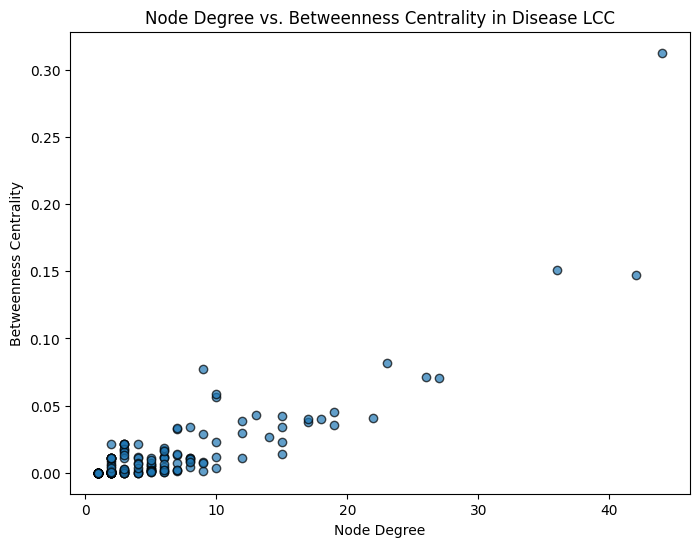

In [ ]:
# Scatterplot of Node Degree vs. Betweenness Centrality
plt.figure(figsize=(8, 6))
plt.scatter(df_summary['Degree'], df_summary['Betweenness'], alpha=0.7, edgecolor='k')
plt.xlabel('Node Degree')
plt.ylabel('Betweenness Centrality')
plt.title('Node Degree vs. Betweenness Centrality in Disease LCC')

# Save and display the plot
plt.savefig('degree_betweenness_scatterplot.png')
plt.show()



> **Comparative analysis of the disease genes identification algorithms**



In [ ]:
with open(r"seed_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in common_genes))

In [ ]:
# Create a DataFrame with GeneA and GeneB columns and save it to PPI.txt
GeneA = human_ppi_data["GeneA"]
GeneB = human_ppi_data["GeneB"]
ppi_df = pd.DataFrame({"GeneA": GeneA, "GeneB": GeneB})

# Save the DataFrame as a CSV file without header and index, using commas as separators
ppi_df.to_csv("PPI.txt", header=None, index=None, sep=",")


In [ ]:
# Write all gene nodes from the PPI graph to a text file, each on a new line
with open("ppi_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in ppi_graph.nodes))

In [ ]:
## Implement a function to make cross-validation
def cross_validation(data, k, seed_genes):
    """
    Perform k-fold cross-validation on seed genes.

    Parameters:
    - data: The data of PPI (not used in this function but included for flexibility).
    - k: Number of folds for cross-validation.
    - seed_genes: List or set of seed genes to be split into training and testing sets.

    Output:
    - Creates and saves seed_test and seed_train files for each fold in the current directory.
    """

    ## Cycle through each fold
    for i in tqdm(range(k), desc="Progress Bar"):

        ## Define the range of indices for the current fold
        fold_min = np.array_split(range(0, len(seed_genes)), k)[i][0]  # Start index for this fold
        fold_max = np.array_split(range(0, len(seed_genes)), k)[i][-1]  # End index for this fold

        ## Define the test seed genes for this fold
        seed_test = list(seed_genes)[fold_min:fold_max]

        ## Save test genes to a file for this fold
        with open(f"seed_test_{i}.txt", "w") as fp:
            fp.write("\n".join(str(item) for item in seed_test))

        ## Define the training seed genes by excluding test genes from the full set
        seed_train = set(seed_genes) - set(seed_test)

        ## Save training genes to a file for this fold
        with open(f"seed_train_{i}.txt", "w") as fp:
            fp.write("\n".join(str(item) for item in seed_train))

In [ ]:
# Required imports
import pandas as pd
import numpy as np
from tqdm import tqdm  # Progress bar for Colab

# Function to run DIAMOnD, DiaBLE, or Diffusion-Based Algorithm with cross-validation
def algorithm(name, k, top_k, t=None):
    """
    Perform k-fold cross-validation on chosen algorithm.

    Parameters:
    - name: Type of algorithm to use ("DIAMOnD", "DiaBLE")
    - k: Number of folds for cross-validation
    - top_k: Number of putative genes to consider
    - t: Arbitrary time for the diffusion algorithm (only used if name is "Diffusion")

    Output:
    - Returns average and standard deviation metrics (Precision, Recall, F1-score)
    """
    ## Define metrics
    precision = []
    recall = []
    f1_score = []

    ## Cycle through folds
    for i in tqdm(range(k), desc="Progress Bar"):

        ## Import test seed genes
        seed_test = pd.read_csv(f"seed_test_{i}.txt", sep="\t", header=None)
        seed_test = set(seed_test.iloc[:, 0].tolist())

        ## Select the algorithm and train
        if name == "DIAMOnD":
            # Run DIAMOnD algorithm
            !python3 DIAMOnD.py PPI.txt seed_train_{i}.txt {top_k}

            ## Evaluate the results
            list_genes = pd.read_csv(f"first_{top_k}_added_nodes_weight_1.txt", sep="\t")
            cv_nodes = set(list_genes[name + "_node"].tolist())  # Get predicted nodes

            ## Compute Precision, Recall, and F1-Score
            TP = len(cv_nodes.intersection(seed_test))  # True Positives
            FP = len(cv_nodes - seed_test)  # False Positives
            FN = len(seed_test - cv_nodes)  # False Negatives

            ## Metrics
            precision.append(TP / (TP + FP + 1e-10))  # Add small epsilon to avoid division by zero
            recall.append(TP / (TP + FN + 1e-10))
            pr_values = TP / (TP + FP)
            rc_values = TP / (TP + FN)
            f1_score.append((2 * pr_values * rc_values) / (pr_values + rc_values + 1e-10))

        elif name == "DiaBLE":
            # Run DiaBLE algorithm
            !python3 DiaBLE.py PPI.txt seed_train_{i}.txt {top_k}

            ## Evaluate the results
            list_genes = pd.read_csv(f"first_{top_k}_added_nodes_weight_1.txt", sep="\t")
            cv_nodes = set(list_genes["DIAMOnD_node"].tolist())  # Get predicted nodes

            ## Compute Precision, Recall, and F1-Score
            TP = len(cv_nodes.intersection(seed_test))  # True Positives
            FP = len(cv_nodes - seed_test)  # False Positives
            FN = len(seed_test - cv_nodes)  # False Negatives

            ## Metrics
            precision.append(TP / (TP + FP + 1e-10))
            recall.append(TP / (TP + FN + 1e-10))
            pr_values = TP / (TP + FP)
            rc_values = TP / (TP + FN)
            f1_score.append((2 * pr_values * rc_values) / (pr_values + rc_values + 1e-10))

    ## Return metrics
    return {
        "Avg_Precision": np.mean(precision),
        "Avg_Recall": np.mean(recall),
        "Avg_F1-Score": np.mean(f1_score),
        "Sd_Precision": np.std(precision),
        "Sd_Recall": np.std(recall),
        "Sd_F1-Score": np.std(f1_score)
    }

In [ ]:
n = len(common_genes)

In [ ]:
cross_validation(ppi_graph, 5, common_genes)


Progress Bar: 100%|██████████| 5/5 [00:00<00:00, 1244.16it/s]




> Diamond Algorithm



In [ ]:
diamond_50  = algorithm("DIAMOnD", 5, 50)
diamond_n   = algorithm("DIAMOnD", 5, n)
diamond_n2  = algorithm("DIAMOnD", 5, int(n/2))
diamond_n4  = algorithm("DIAMOnD", 5, int(n/4))
diamond_n10 = algorithm("DIAMOnD", 5, int(n/10))

Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [00:30<02:00, 30.05s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [00:59<01:28, 29.51s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [01:27<00:58, 29.07s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [01:56<00:29, 29.06s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [03:09<12:39, 189.78s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [06:12<09:17, 185.85s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [09:19<06:12, 186.27s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [12:29<03:07, 187.52s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [01:28<05:53, 88.50s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [02:57<04:26, 88.79s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [04:27<02:58, 89.39s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [05:54<01:28, 88.24s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [00:45<03:03, 45.81s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [01:32<02:19, 46.34s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [02:19<01:33, 46.56s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [03:05<00:46, 46.22s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [00:22<01:30, 22.51s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [00:43<01:04, 21.62s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [01:03<00:41, 20.97s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [01:24<00:20, 20.94s/it]

/content/DIAMOnD.py:410: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar: 100%|██████████| 5/5 [01:46<00:00, 21.39s/it]


In [ ]:
## Collect the performances in a table
raw_data = {"Avg_Precision": [diamond_50["Avg_Precision"], diamond_n["Avg_Precision"],
                              diamond_n2["Avg_Precision"], diamond_n4["Avg_Precision"], diamond_n10["Avg_Precision"]],
            "Avg_Recall": [diamond_50["Avg_Recall"], diamond_n["Avg_Recall"],
                              diamond_n2["Avg_Recall"], diamond_n4["Avg_Recall"], diamond_n10["Avg_Recall"]],
            "Avg_F1_Score": [diamond_50["Avg_F1-Score"], diamond_n["Avg_F1-Score"],
                              diamond_n2["Avg_F1-Score"], diamond_n4["Avg_F1-Score"], diamond_n10["Avg_F1-Score"]],
            "Sd_Precision": [diamond_50["Sd_Precision"], diamond_n["Sd_Precision"],
                              diamond_n2["Sd_Precision"], diamond_n4["Sd_Precision"], diamond_n10["Sd_Precision"]],
            "Sd_Recall": [diamond_50["Sd_Recall"], diamond_n["Sd_Recall"],
                              diamond_n2["Sd_Recall"], diamond_n4["Sd_Recall"], diamond_n10["Sd_Recall"]],
            "Sd_F1_Score": [diamond_50["Sd_F1-Score"], diamond_n["Sd_F1-Score"],
                              diamond_n2["Sd_F1-Score"], diamond_n4["Sd_F1-Score"], diamond_n10["Sd_F1-Score"]]}

## Rename columns
df_diamond = pd.DataFrame(raw_data)
df_diamond = df_diamond.rename(index = {0:"Diamond_50", 1:"Diamond_n", 2:"Diamond_N/2", 3:"Diamond_N/4", 4:"Diamond_N/10"})

In [ ]:
df_diamond

,Avg_Precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
Diamond_50,0.056000,0.049624,0.052619,0.038781,0.034591,0.036565
Diamond_n,0.015278,0.077820,0.025541,0.008099,0.041302,0.013541
Diamond_N/2,0.026389,0.067231,0.037900,0.017236,0.043821,0.024739
Diamond_N/4,0.047222,0.060213,0.052931,0.028599,0.036568,0.032095
Diamond_N/10,0.078571,0.038972,0.052101,0.061445,0.030652,0.040900


In [ ]:
df_diamond.to_csv("Diamond_Performances.csv")



> Diable Algorithm



In [ ]:
diable_50  = algorithm(name = "DiaBLE", k = 5, top_k = 50)
diable_n  = algorithm(name = "DiaBLE", k = 5, top_k = n)
diable_n2  = algorithm("DiaBLE", 5, int(n/2))
diable_n4  = algorithm("DiaBLE", 5, int(n/4))
diable_n10 = algorithm("DiaBLE", 5, int(n/10))

Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [00:45<03:01, 45.32s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [01:30<02:15, 45.02s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [02:15<01:30, 45.11s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [03:00<00:44, 44.96s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_50_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [04:25<17:42, 265.59s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [08:52<13:18, 266.11s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [13:42<09:14, 277.38s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [18:20<04:37, 277.67s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_288_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [02:10<08:43, 130.76s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [04:18<06:27, 129.11s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [06:25<04:15, 127.89s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [08:33<02:07, 127.91s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_144_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [01:10<04:42, 70.52s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [02:17<03:24, 68.21s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [03:23<02:15, 67.52s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [04:31<01:07, 67.43s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_72_added_nodes_weight_1.txt' 



Progress Bar:   0%|          | 0/5 [00:00<?, ?it/s]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  20%|██        | 1/5 [00:28<01:55, 28.84s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  40%|████      | 2/5 [00:56<01:25, 28.42s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  60%|██████    | 3/5 [01:24<00:55, 27.83s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar:  80%|████████  | 4/5 [01:51<00:27, 27.71s/it]

/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_28_added_nodes_weight_1.txt' 



Progress Bar: 100%|██████████| 5/5 [02:19<00:00, 27.89s/it]


In [ ]:
## Collect the performances in a table for DiaBLE
raw_data = {"Avg_Precision": [diable_50["Avg_Precision"], diable_n["Avg_Precision"],
                              diable_n2["Avg_Precision"], diable_n4["Avg_Precision"], diable_n10["Avg_Precision"]],
            "Avg_Recall": [diable_50["Avg_Recall"], diable_n["Avg_Recall"],
                           diable_n2["Avg_Recall"], diable_n4["Avg_Recall"], diable_n10["Avg_Recall"]],
            "Avg_F1_Score": [diable_50["Avg_F1-Score"], diable_n["Avg_F1-Score"],
                             diable_n2["Avg_F1-Score"], diable_n4["Avg_F1-Score"], diable_n10["Avg_F1-Score"]],
            "Sd_Precision": [diable_50["Sd_Precision"], diable_n["Sd_Precision"],
                             diable_n2["Sd_Precision"], diable_n4["Sd_Precision"], diable_n10["Sd_Precision"]],
            "Sd_Recall": [diable_50["Sd_Recall"], diable_n["Sd_Recall"],
                          diable_n2["Sd_Recall"], diable_n4["Sd_Recall"], diable_n10["Sd_Recall"]],
            "Sd_F1_Score": [diable_50["Sd_F1-Score"], diable_n["Sd_F1-Score"],
                            diable_n2["Sd_F1-Score"], diable_n4["Sd_F1-Score"], diable_n10["Sd_F1-Score"]]}

## Rename rows and create DataFrame for DiaBLE results
df_diable = pd.DataFrame(raw_data)
df_diable = df_diable.rename(index={0: "DiaBLE_50", 1: "DiaBLE_n", 2: "DiaBLE_N/2", 3: "DiaBLE_N/4", 4: "DiaBLE_N/10"})

In [ ]:
df_diable

,Avg_Precision,Avg_Recall,Avg_F1_Score,Sd_Precision,Sd_Recall,Sd_F1_Score
DiaBLE_50,0.056000,0.049624,0.052619,0.038781,0.034591,0.036565
DiaBLE_n,0.015278,0.077820,0.025541,0.008099,0.041302,0.013541
DiaBLE_N/2,0.026389,0.067231,0.037900,0.017236,0.043821,0.024739
DiaBLE_N/4,0.047222,0.060213,0.052931,0.028599,0.036568,0.032095
DiaBLE_N/10,0.078571,0.038972,0.052101,0.061445,0.030652,0.040900


In [ ]:
df_diable.to_csv("Diable_Performances.csv")



> Diffusion Algorithm results



In [ ]:
import pandas as pd

# Load the data from each file, adding the time (t) as a new column
file_paths = {
    "0.01": "diffusion_results01.txt",
    "0.002": "diffusion_results02.txt",
    "0.005": "diffusion_results05.txt"
}

# Initialize an empty DataFrame to collect all data
all_data = pd.DataFrame()

# Read each file and append to all_data with the time information
for t, path in file_paths.items():
    df = pd.read_csv(path, delimiter=": ", engine='python', names=["Gene", "Score"])
    df["t"] = t  # Add the time as a new column
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by time (t) and score, then assign rank within each time
all_data = all_data.sort_values(by=["t", "Score"], ascending=[True, False])
all_data["Rank"] = all_data.groupby("t")["Score"].rank(method="first", ascending=False)

# Create and display separate tables for each time (t) value
tables = {t: all_data[all_data["t"] == t].sort_values(by="Rank") for t in file_paths.keys()}

# Display each table
for t, table in tables.items():
    print(f"Table for t = {t}")
    display(table[["Gene", "Score", "Rank"]])
    print("\n\n")

Table for t = 0.01


,Gene,Score,Rank
20108,MIR130A,0.9902,1.0
6843,CCKAR,0.9901,2.0
11112,GIPR,0.9885,3.0
13110,NPY5R,0.9805,4.0
19049,BDNF-AS,0.9805,5.0
...,...,...,...
20026,TRAV38-2DV8,0.0000,20117.0
20069,MIR181A1HG,0.0000,20118.0
20072,SPATA45,0.0000,20119.0
20077,CD163L1,0.0000,20120.0





Table for t = 0.002


,Gene,Score,Rank
26964,CCKAR,0.9980,1.0
40229,MIR130A,0.9980,2.0
31233,GIPR,0.9979,3.0
27383,MC3R,0.9969,4.0
39170,BDNF-AS,0.9961,5.0
...,...,...,...
40237,ZNF208,0.0000,20117.0
40238,ZNF98,0.0000,20118.0
40239,ZNF681,0.0000,20119.0
40240,MIR205HG,0.0000,20120.0





Table for t = 0.005


,Gene,Score,Rank
60350,MIR130A,0.9951,1.0
47085,CCKAR,0.9950,2.0
51354,GIPR,0.9946,3.0
47504,MC3R,0.9909,4.0
53352,NPY5R,0.9902,5.0
...,...,...,...
60352,KBTBD11-OT1,0.0000,20117.0
60353,QRFP,0.0000,20118.0
60354,LOC284023,0.0000,20119.0
60355,MIR1469,0.0000,20120.0


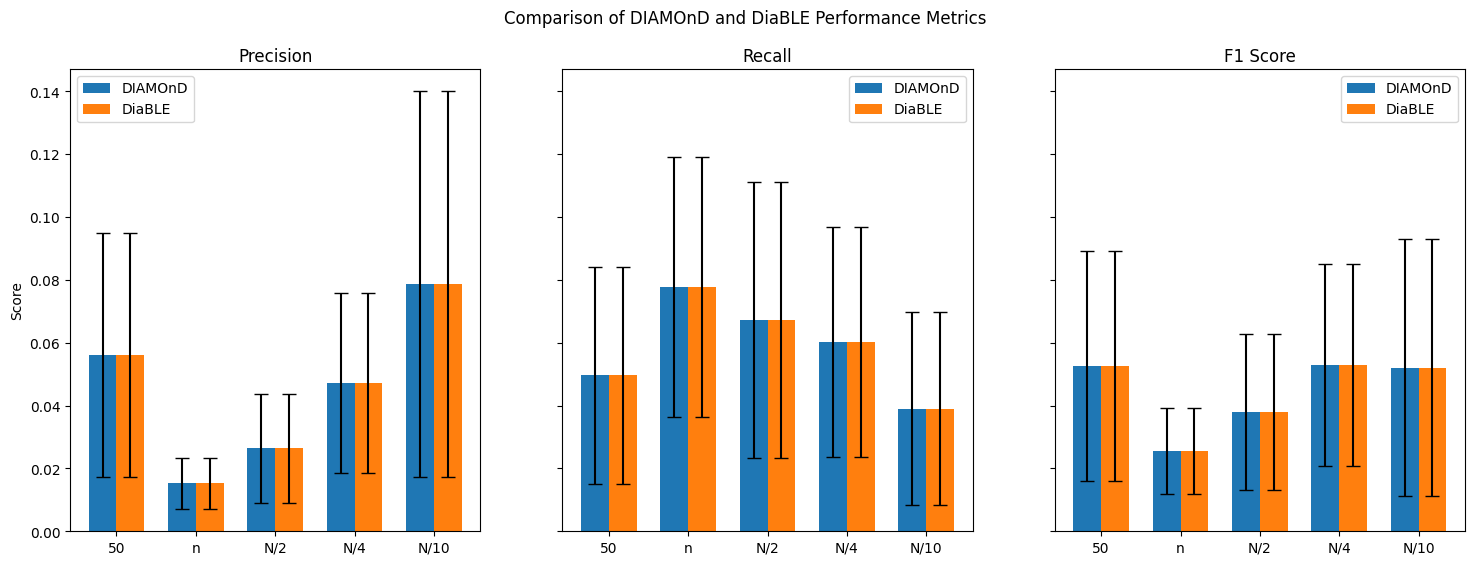

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up positions for the bars
labels = ["50", "n", "N/2", "N/4", "N/10"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

# 1. Bar Chart with Error Bars for Precision, Recall, and F1-Score
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Precision
ax[0].bar(x - width/2, df_diamond["Avg_Precision"], width, yerr=df_diamond["Sd_Precision"], label="DIAMOnD", capsize=5)
ax[0].bar(x + width/2, df_diable["Avg_Precision"], width, yerr=df_diable["Sd_Precision"], label="DiaBLE", capsize=5)
ax[0].set_title("Precision")
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel("Score")
ax[0].legend()

# Recall
ax[1].bar(x - width/2, df_diamond["Avg_Recall"], width, yerr=df_diamond["Sd_Recall"], label="DIAMOnD", capsize=5)
ax[1].bar(x + width/2, df_diable["Avg_Recall"], width, yerr=df_diable["Sd_Recall"], label="DiaBLE", capsize=5)
ax[1].set_title("Recall")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

# F1 Score
ax[2].bar(x - width/2, df_diamond["Avg_F1_Score"], width, yerr=df_diamond["Sd_F1_Score"], label="DIAMOnD", capsize=5)
ax[2].bar(x + width/2, df_diable["Avg_F1_Score"], width, yerr=df_diable["Sd_F1_Score"], label="DiaBLE", capsize=5)
ax[2].set_title("F1 Score")
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()

fig.suptitle("Comparison of DIAMOnD and DiaBLE Performance Metrics")
plt.show()

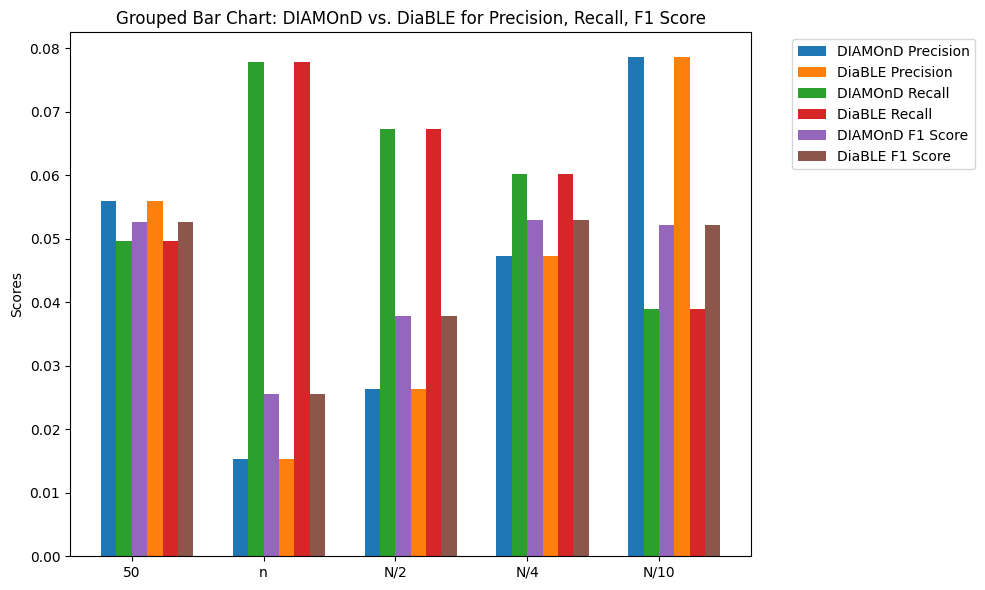

In [ ]:
metrics = ["Avg_Precision", "Avg_Recall", "Avg_F1_Score"]
metric_labels = ["Precision", "Recall", "F1 Score"]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
for i, metric in enumerate(metrics):
    ax.bar(x - width/2 + i * width / len(metrics), df_diamond[metric], width / len(metrics), label=f"DIAMOnD {metric_labels[i]}")
    ax.bar(x + width/2 + i * width / len(metrics), df_diable[metric], width / len(metrics), label=f"DiaBLE {metric_labels[i]}")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Scores")
ax.set_title("Grouped Bar Chart: DIAMOnD vs. DiaBLE for Precision, Recall, F1 Score")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



> **Best algorithm choice and putative disease gene identification**




In [ ]:
!python3 DiaBLE.py PPI.txt seed_genes.txt 100


/content/DiaBLE.py:418: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])

 results have been saved to 'first_100_added_nodes_weight_1.txt' 



In [ ]:
list_genes = pd.read_csv(f"first_100_added_nodes_weight_1.txt", sep = "\t")

## Select the top k genes
cv_nodes = list_genes["DIAMOnD_node"].tolist()
cv_nodes

['NCOA2',
 'NCOA1',
 'NCOR2',
 'RXRA',
 'NCOA6',
 'PPARGC1A',
 'SP1',
 'ARNT',
 'VDR',
 'RXRG',
 'RARA',
 'NCOR1',
 'NR1H4',
 'RXRB',
 'THRB',
 'POU2F1',
 'RELA',
 'CREBBP',
 'RARG',
 'HNF4A',
 'NRIP1',
 'RARB',
 'ESRRA',
 'NR0B1',
 'PSMC5',
 'PIAS1',
 'SMAD3',
 'HIF1A',
 'HDAC3',
 'JUN',
 'KAT2B',
 'MAPK1',
 'SMARCD3',
 'ETS1',
 'MED23',
 'POU1F1',
 'MED1',
 'EPAS1',
 'MED24',
 'THRA',
 'MED14',
 'UBE2I',
 'NR3C2',
 'MED15',
 'MED6',
 'MED7',
 'MED17',
 'MED16',
 'MED25',
 'MED13',
 'MED21',
 'CDK8',
 'MED8',
 'MED22',
 'MED13L',
 'MED10',
 'MED12',
 'MED12L',
 'MED11',
 'MED18',
 'CDK19',
 'MED27',
 'MED30',
 'MED19',
 'MED26',
 'MED9',
 'MED29',
 'MED20',
 'MED28',
 'MED31',
 'CCNC',
 'ACAD11',
 'FBXL19',
 'POLR2I',
 'POLR2H',
 'MED4',
 'POLR2G',
 'RPAP2',
 'POLR2A',
 'POLR2E',
 'POLR2D',
 'POLR2M',
 'POLR2B',
 'POLR2J',
 'GTF2B',
 'POLR2C',
 'POLR2F',
 'CTDP1',
 'SCAF4',
 'POLR2K',
 'POLR2L',
 'RPRD2',
 'RECQL5',
 'TCL1B',
 'ZC3H13',
 'TADA2A',
 'APOA2',
 'GPN3',
 'POLR3E',
 'ZNRD1

In [ ]:
## Check
list_genes

,#rank,DIAMOnD_node,p_hyper
0,1,NCOA2,8.647933e-13
1,2,NCOA1,6.135276e-13
2,3,NCOR2,2.587229e-09
3,4,RXRA,6.517637e-10
4,5,NCOA6,1.387239e-10
...,...,...,...
95,96,TADA2A,1.173355e-18
96,97,APOA2,1.283809e-18
97,98,GPN3,2.701889e-17
98,99,POLR3E,1.741274e-16




> **Drug Repursoring**



In [ ]:
first20 = cv_nodes[:20]
## First 20 putative disease genes
with open(r"20_putative_genes.txt", "w") as fp:
    fp.write("\n".join(str(item) for item in first20))

In [ ]:
interactions = pd.read_csv("interactions.tsv", sep = "\t")

In [ ]:
interactions

,gene_claim_name,gene_concept_id,gene_name,interaction_source_db_name,interaction_source_db_version,interaction_type,interaction_score,drug_claim_name,drug_concept_id,drug_name,approved,immunotherapy,anti_neoplastic
0,CYP2D6,hgnc:2625,CYP2D6,DTC,9/2/20,NaN,0.017709,RACLOPRIDE,ncit:C152139,RACLOPRIDE,False,False,False
1,PPARG,hgnc:9236,PPARG,DTC,9/2/20,NaN,0.840123,KALOPANAX-SAPONIN F,chembl:CHEMBL1833984,CHEMBL:CHEMBL1833984,False,False,False
2,ATAD5,hgnc:25752,ATAD5,DTC,9/2/20,NaN,0.177992,RO-5-3335,chembl:CHEMBL91609,CHEMBL:CHEMBL91609,False,False,False
3,RGS4,hgnc:10000,RGS4,DTC,9/2/20,NaN,0.034319,"3,4-DICHLOROISOCOUMARIN",drugbank:DB04459,"3,4-DICHLOROISOCOUMARIN",False,False,False
4,MAPK1,hgnc:6871,MAPK1,DTC,9/2/20,NaN,0.050007,WITHAFERIN A,iuphar.ligand:13097,WITHAFERIN A,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98234,TP53,hgnc:11998,TP53,JAX-CKB,10-Apr-24,NaN,0.014489,PD-0325901,ncit:C52195,MIRDAMETINIB,False,False,True
98235,TP53,hgnc:11998,TP53,JAX-CKB,10-Apr-24,NaN,0.115911,ALRN-6924,ncit:C118669,SULANEMADLIN,False,False,False
98236,TP53,hgnc:11998,TP53,JAX-CKB,10-Apr-24,NaN,0.025758,LY3009120,iuphar.ligand:8943,LY3009120,False,False,False
98237,TP53,hgnc:11998,TP53,JAX-CKB,10-Apr-24,NaN,0.010537,Cabozantinib,rxcui:1363267,CABOZANTINIB S-MALATE,True,False,True


In [ ]:
import pandas as pd

# Load interactions TSV file
interactions_df = pd.read_csv("interactions.tsv", sep='\t')

# List of target genes from your file
target_genes = [
    "NCOA2", "NCOA1", "NCOR2", "RXRA", "NCOA6",
    "PPARGC1A", "SP1", "ARNT", "VDR", "RXRG",
    "RARA", "NCOR1", "NR1H4", "RXRB", "THRB",
    "POU2F1", "RELA", "CREBBP", "RARG", "HNF4A"
]

# Filter interactions based on target genes
filtered_df = interactions_df[interactions_df['gene_name'].isin(target_genes)]

# Ensure 'approved' column is treated as a string for aggregation
filtered_df['approved'] = filtered_df['approved'].astype(str)

# Group by drug_name and aggregate the required information
drug_summary = (
    filtered_df.groupby('drug_name')
    .agg(
        gene_count=('gene_name', 'nunique'),  # Count unique associated genes
        associated_genes=('gene_name', lambda x: ', '.join(x.unique())),  # Concatenate gene names
        avg_interaction_score=('interaction_score', 'mean'),  # Average interaction score
        approved_status=('approved', lambda x: ', '.join(x.dropna().unique()))  # List unique approved statuses
    )
    .reset_index()
)

# Sort by gene count in descending order
ranked_drugs = drug_summary.sort_values(by='gene_count', ascending=False)

# Display the result
print("Top drugs with gene associations, average interaction scores, approval status, and associated genes:")
print(ranked_drugs)

# Save the output to a CSV file
ranked_drugs.to_csv("ranked_drug_gene_associations_with_genes.csv", index=False)


Top drugs with gene associations, average interaction scores, approval status, and associated genes:
                                             drug_name  gene_count  \
47                                           ACITRETIN           6   
742                                          TRETINOIN           6   
56                                        ALITRETINOIN           6   
48                                           ADAPALENE           5   
383                                         ETRETINATE           5   
..                                                 ...         ...   
276                                         CLIOQUINOL           1   
277                                     CLODRONIC ACID           1   
278                                        CLOFENOXYDE           1   
279                                         CLONAZEPAM           1   
801  {4-[3-(4-ACETYL-3-HYDROXY-2-PROPYLPHENOXY)PROP...           1   

                      associated_genes  avg_interaction_sc

<ipython-input-102-d8a8f56174cf>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['approved'] = filtered_df['approved'].astype(str)
